In [1]:
#import liabraries
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data


In [2]:
#import zip file
import zipfile

zip_path = "X-ray_dataset.zip"  # make sure filename matches exactly
extract_to = "images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")


Extraction completed!


In [1]:
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python albumentations gradio


  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached gradio-6.0.1-py3-none-any.whl.metadata (16 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached stringzilla-4.3.0-cp313-cp313-win_amd64.whl.metadata (112 kB)
  Using cached simsimd-6.5.3-cp313-cp313-win_amd64.whl.metadata (71 kB)
  Using cached aiofiles-24.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached audioop_lts-0.2.2-cp313-abi3-win_amd64.whl.metadata (2.0 kB)
  Using cached brotli-1.2.0-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached fastapi-0.122.0-py3-none-any.whl.metadata (30 kB)
  Using cached ffmpy-1.0.0-py3-none-any.whl.metadata (3.0 kB)
  Using cached gradio_client-2.0.0-py3-none-any.whl.metadata (7.1 kB)
  Using cached groovy-0.1.2-py3-none-any.whl.metadata (6.1 kB)
  Using cac

  You can safely remove it manually.
  You can safely remove it manually.



   --------------------- ------------------ 20.7/38.9 MB 148.7 kB/s eta 0:02:03
   --------------------- ------------------ 20.7/38.9 MB 148.7 kB/s eta 0:02:03
   --------------------- ------------------ 21.0/38.9 MB 150.4 kB/s eta 0:02:00
   --------------------- ------------------ 21.0/38.9 MB 150.4 kB/s eta 0:02:00
   --------------------- ------------------ 21.0/38.9 MB 150.4 kB/s eta 0:02:00
   --------------------- ------------------ 21.0/38.9 MB 150.4 kB/s eta 0:02:00
   --------------------- ------------------ 21.0/38.9 MB 150.4 kB/s eta 0:02:00
   --------------------- ------------------ 21.2/38.9 MB 154.3 kB/s eta 0:01:55
   --------------------- ------------------ 21.2/38.9 MB 154.3 kB/s eta 0:01:55
   --------------------- ------------------ 21.2/38.9 MB 154.3 kB/s eta 0:01:55
   --------------------- ------------------ 21.2/38.9 MB 154.3 kB/s eta 0:01:55
   --------------------- ------------------ 21.2/38.9 MB 154.3 kB/s eta 0:01:55
   --------------------- --------------

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.optimizers import Adam, SGD, RMSprop


In [4]:
import os

print(os.listdir("images"))


['chest_xray']


In [8]:
import os

print("Exists:", os.path.exists("chest_xray"))
print("Folders:", os.listdir("chest_xray") if os.path.exists("chest_xray") else "Folder not found")


Exists: False
Folders: Folder not found


In [5]:
data_dir = "images"  # folder containing 'PNEUMONIA' and 'NORMAL'

# Example Image Dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16


#Image Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 4685 images belonging to 1 classes.
Found 1171 images belonging to 1 classes.


In [6]:
#Build Models
def build_custom_cnn(input_shape=(224,224,3)):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

custom_cnn = build_custom_cnn()
custom_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


C:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
#Transfer Learning (VGG16 example)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

vgg16_model = Model(inputs=base_model.input, outputs=output)
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [10]:
#Train the Models
history = custom_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=2
)


Epoch 1/2
293/293 ━━━━━━━━━━━━━━━━━━━━ 954s 3s/step - accuracy: 0.9998 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/2
293/293 ━━━━━━━━━━━━━━━━━━━━ 816s 3s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


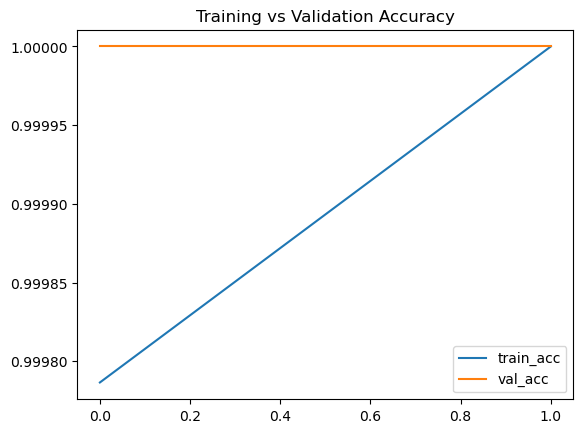

In [11]:
#Plot Training Curves
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()
